In [148]:
# Import important library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, roc_curve, auc
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

### Q1 Read the input file and check the data dimension

In [149]:
# You can access from https://www.kaggle.com/uciml/german-credit
#Read input file and understand the data
# "default" is my dependent variable

In [150]:
data = pd.read_csv('german_credit.csv')

In [151]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
default                       1000 non-null int64
account_check_status          1000 non-null object
duration_in_month             1000 non-null int64
credit_history                1000 non-null object
purpose                       1000 non-null object
credit_amount                 1000 non-null int64
savings                       1000 non-null object
present_emp_since             1000 non-null object
installment_as_income_perc    1000 non-null int64
personal_status_sex           1000 non-null object
other_debtors                 1000 non-null object
present_res_since             1000 non-null int64
property                      1000 non-null object
age                           1000 non-null int64
other_installment_plans       1000 non-null object
housing                       1000 non-null object
credits_this_bank             1000 non-null int64
job                           1000

**Splitting the colum having gender and personal_status into two columns**

In [152]:
sex_status = data['personal_status_sex'].str.split(" : ", n = 1, expand = True)
data['sex'] = sex_status[0]
data['personal_status'] = sex_status[1]
data.drop(columns='personal_status_sex',inplace=True)

In [153]:
# Lets build a Ensemble model but need to modify the dataset first


### Q2.Prepare the model data by converting non-numeric to dummy ( 1 Marks)
##### Hint: Use get_dummies

In [154]:
# Print Shape of model data
data.shape

(1000, 22)

In [155]:
X = data.drop(columns='default')
y = data['default']
X_numeric = pd.get_dummies(X)

In [156]:
X_numeric.shape

(1000, 63)

### Check for highly correlated variables but don't required any treatment for this use case

In [157]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print("\033[1mTop Absolute Correlations\033[0m")
print(get_top_abs_correlations(X_numeric, 10))

Top Absolute Correlations
telephone_none                              telephone_yes, registered under the customers name     1.000000
foreign_worker_no                           foreign_worker_yes                                     1.000000
sex_male                                    personal_status_divorced/separated/married             1.000000
sex_female                                  personal_status_divorced/separated/married             1.000000
                                            sex_male                                               1.000000
other_installment_plans_bank                other_installment_plans_none                           0.840546
property_unknown / no property              housing_for free                                       0.779853
sex_male                                    personal_status_single                                 0.738036
sex_female                                  personal_status_single                                 0.738036
pe

### Drop the original variables which are converted to dummy

In [158]:
X_numeric.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 63 columns):
duration_in_month                                                             1000 non-null int64
credit_amount                                                                 1000 non-null int64
installment_as_income_perc                                                    1000 non-null int64
present_res_since                                                             1000 non-null int64
age                                                                           1000 non-null int64
credits_this_bank                                                             1000 non-null int64
people_under_maintenance                                                      1000 non-null int64
account_check_status_0 <= ... < 200 DM                                        1000 non-null uint8
account_check_status_< 0 DM                                                   1000 non-null uint8
account_chec

**The original variables are already dropped when using pd.get_dummies**

### Q3 Split Train/Test data 70:30 ratio( 1 Marks)
##### Hint:from sklearn.model_selection import train_test_split

In [159]:
X_train, X_test, y_train, y_test = train_test_split(X_numeric, y, test_size=0.3,random_state=0)

### Q4 Build Random Forest Model( 1 Marks)
#### Hint:from sklearn.ensemble import RandomForestClassifier using n_jobs=2,n_estimators=500,criterion="entropy",random_state=9999

In [160]:
rfcl = RandomForestClassifier(n_jobs=2,n_estimators = 500,criterion='entropy',random_state=9999)
rfcl.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=2,
            oob_score=False, random_state=9999, verbose=0,
            warm_start=False)

In [161]:
predicted_test = rfcl.predict(X_test)

### Q5 Calculate Confusion Matrix and Accuracy score (1 Marks)
##### Hint: Use confusion_matrix and accuracy_score

In [162]:
print('Testing Accuracy:',accuracy_score(y_test,predicted_test))

Testing Accuracy: 0.78


[Text(0, 0.5, '0'), Text(0, 1.5, '1')]

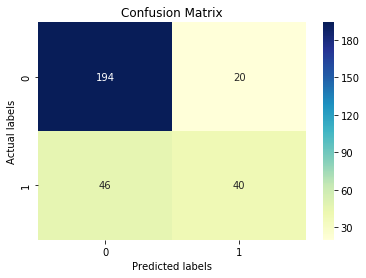

In [163]:
credit_default = list(y.unique())
cm = confusion_matrix(y_test,predicted_test,labels=credit_default)
ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt='d', ax = ax, cmap="YlGnBu")

# labels, title and ticks
ax.set_title('Confusion Matrix')
ax.set_xlabel('Predicted labels')
ax.set_ylabel('Actual labels')
ax.xaxis.set_ticklabels(credit_default,ha='center')
ax.yaxis.set_ticklabels(credit_default,va='center')

### Q6 Show the list of the features importance( 1 Marks)

In [164]:
feature_imp = {'feature':X_numeric.columns,'importance':rfcl.feature_importances_}
feature_imp_df = pd.DataFrame(feature_imp)
feature_imp_df

,feature,importance
0,duration_in_month,0.077496
1,credit_amount,0.097537
2,installment_as_income_perc,0.032301
3,present_res_since,0.033661
4,age,0.074115
5,credits_this_bank,0.019255
6,people_under_maintenance,0.012972
7,account_check_status_0 <= ... < 200 DM,0.016754
8,account_check_status_< 0 DM,0.035498
9,account_check_status_>= 200 DM / salary assign...,0.008793


### Q7 K-fold cross-validation( 2 Marks)
##### k-fold cross validation( without stratification)
##### Usually k is set as 10-20 in practical settings, depends on data set size

In [165]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [166]:
# Use below values
num_folds = 10
seed = 77

In [167]:
#Validate the Random Forest model build above using k fold

In [168]:
rfcl = RandomForestClassifier(n_jobs=2,n_estimators = 500,criterion='entropy',random_state=seed)
kf = KFold(n_splits=num_folds,random_state=seed)

In [169]:
accuracy_scores = []
for train_index, test_index in kf.split(X_numeric):
    X_train, X_test = X_numeric.iloc[train_index], X_numeric.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    rfcl.fit(X_train,y_train)
    predicted_test = rfcl.predict(X_test)
    accuracy_scores.append(accuracy_score(y_test,predicted_test))
print('Accuracy Scores:',accuracy_scores)

Accuracy Scores: [0.87, 0.7, 0.78, 0.81, 0.79, 0.69, 0.78, 0.81, 0.76, 0.76]


In [170]:
cross_val_scores = cross_val_score(rfcl,X_numeric,y,cv=kf)
print('Cross Validation Scores:',cross_val_scores)

Cross Validation Scores: [0.87 0.7  0.78 0.81 0.79 0.69 0.78 0.81 0.76 0.76]


In [171]:
#Calculate Mean score

In [172]:
print('Mean Score =',np.mean(cross_val_scores))

Mean Score = 0.775


In [173]:
# Calculate score standard deviation using std()

In [174]:
print('Score Standard Deviation =',np.std(cross_val_scores))

Score Standard Deviation = 0.050049975024968815


# Q8 Print the confusion matrix( 1 Marks)

In [175]:
y_pred = cross_val_predict(rfcl, X_numeric, y, cv=kf)

[Text(0, 0.5, '0'), Text(0, 1.5, '1')]

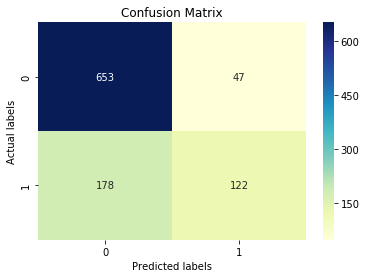

In [176]:
credit_default = list(y.unique())
cm = confusion_matrix(y,y_pred,labels=credit_default)
ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt='d', ax = ax, cmap="YlGnBu")

# labels, title and ticks
ax.set_title('Confusion Matrix')
ax.set_xlabel('Predicted labels')
ax.set_ylabel('Actual labels')
ax.xaxis.set_ticklabels(credit_default,ha='center')
ax.yaxis.set_ticklabels(credit_default,va='center')

# Q9.Classification accuracy: 
percentage of correct predictions and Calculate sensitivity (or True Positive Rate or Recall) and Precision.
( 1 Marks)

In [177]:
print('Accuracy:',accuracy_score(y,y_pred))

Accuracy: 0.775


In [178]:
print('Sensitivity:',recall_score(y,y_pred))
print('Precision:',precision_score(y,y_pred))

Sensitivity: 0.4066666666666667
Precision: 0.7218934911242604


# Q10.Plot Receiver Operating Characteristic (ROC) Curves( 1 Marks)

In [179]:
#Hint: Use roc_curve

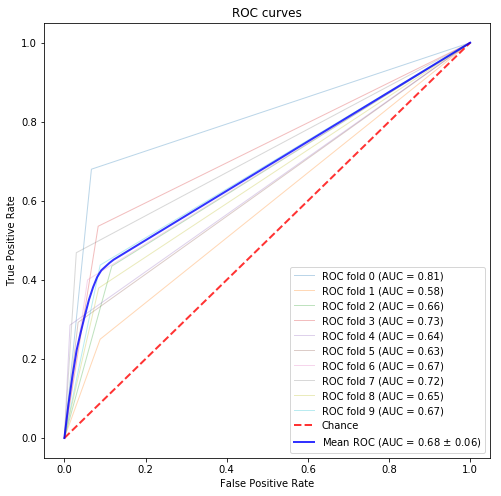

In [181]:
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

i = 0
for train_index, test_index in kf.split(X_numeric):
    X_train, X_test = X_numeric.iloc[train_index], X_numeric.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    rfcl.fit(X_train,y_train)
    predicted_test = rfcl.predict(X_test)
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y_test, predicted_test)
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    i += 1
    
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b', label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)


plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves')
plt.legend(loc="lower right")
plt.rcParams['figure.figsize']=(10,10)
plt.show()

ROC curve can help you to choose a threshold that balances sensitivity and specificity in a way that makes sense for your particular context

# Q11. Calculate AUC(the percentage of the ROC plot that is underneath the curve) - optional

The AUCs are already calculated in the previous question, and are shown in the plot legend.

### Bootstrapping ( Bonus)
##### Given a dataset of size n, a bootstrap sample is created by sampling n instances uniformly from the data (with/without replacement)
##### Create a model with each bootstrap sample and validate it with the test set
##### Final result is calculated by averaging the accuracy of models

In [182]:
# Number of iterations for bootstrapping
bootstrap_iteration = 10
accuracy = []

In [183]:
from sklearn.utils import resample
from sklearn.metrics import accuracy_score

for i in range(bootstrap_iteration):
    X_, y_ = resample(X_train, y_train)
    rfcl.fit(X_, y_)
    y_pred = rfcl.predict(X_test)
    
    acc = accuracy_score(y_pred, y_test)
    accuracy.append(acc)

In [184]:
accuracy = np.array(accuracy)
print('Accuracy Score')
print('Avearge: ', accuracy.mean())
print('Standard deviation: ', accuracy.std())

Accuracy Score
Avearge:  0.741
Standard deviation:  0.030479501308256367
